# 1.G: Including inefficiency and background in the model

Suppose that the detector only records a fraction of all decays that occur.
If we do not account for such inefficiencies, our estimator for the activity
may be biased.

Model this by including a third parameter: the efficiency, $\epsilon$.

$$N = N_a + N_b$$

$$E[N] = E[N_a]+E[N_b] = \epsilon\, a\times t + b\times t$$

If the efficiency, $\epsilon$, and background rate, $b$, are well known,
a simple point estimate, $\hat{a}=(n/t - b)/\epsilon$, might be suitable. 
Unfortunately $\epsilon$ and $b$ are not known.

In [1]:
# Import modules needed for this tutorial

from trisep.RadioactiveSource import RadioactiveSource
from trisep.RadiationCounter import RadiationCounter, SimulatedRadiationCounter
from trisep.MarkovChain import MarkovChain
import copy
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background') # only include this if you use a dark background for Jupyter Lab

from iminuit import Minuit

For this experiment, we determine the efficiency by operating the detector with a
calibrated source inside.

In [2]:
# run the detector for 30 seconds with a calibrated source that is 30 Bq.

calib_detector = RadiationCounter()
calib_source = RadioactiveSource(30.)

calib_detector.insert_calibration_source(calib_source)
calib_detector.set_counting_time(30.)
calib_time = calib_detector.get_counting_time()

calib_detector.start()
calib_count = calib_detector.get_count()
print('The lab detector counted',calib_count,'decays in',calib_time,' seconds with the calibrated source')


Lab radiation counter built. Default counting time is 10.0 seconds.
The calibration source has been inserted into the counter
Measurement has begun. Please wait 30.0 seconds.
Number of counts observed in 30.0 seconds was 777
The lab detector counted 777 decays in 30.0  seconds with the calibrated source


## Point estimate for activity

Use the joint likelihood function, ${\cal L}(a,b,\epsilon)$, and find the values of the parameters that maximize the likelihood.

The three measurements are independent, so the joint likelihood function is the product
of the individual likelihood functions:

$${\cal L}(a,b,\epsilon) = {\cal L}_{\rm lab}(a,b,\epsilon) \times {\cal L}_{\rm control}(b)\times {\cal L}_{\rm calib}(b,\epsilon)$$

With 3 parameters, we need to use numerical approaches to find the parameters that maximize the likelihood function. The code below uses the iminuit package to do that.

In [3]:
observed = 6
observed_control = 5
observed_calib = 826

# make model of calibration experiment (calibrated source)

sim_calib_detector = SimulatedRadiationCounter()
sim_calib_detector.insert_calibration_source(calib_source)
sim_calib_detector.set_counting_time(30.)

# make model of control experiment (no source)

sim_control_detector = SimulatedRadiationCounter()
sim_control_detector.set_counting_time(30.)

# make model of experiment with a source

simulated_source = RadioactiveSource(0.6) # specifies the activity of simulated source

sim_detector = SimulatedRadiationCounter()
sim_detector.set_counting_time(10)
sim_detector.insert_calibration_source(simulated_source)


def get_neg_log_likelihood(a,b,eps):
    simulated_source.set_activity(a)
    sim_detector.set_background(b)
    sim_detector.set_efficiency(eps)
    sim_likelihood = sim_detector.get_likelihood(observed)

    sim_control_detector.set_background(b)
    sim_control_likelihood = sim_control_detector.get_likelihood(observed_control)

    sim_calib_detector.set_background(b)
    sim_calib_detector.set_efficiency(eps)
    sim_calib_likelihood = sim_calib_detector.get_likelihood(observed_calib)

    return -1*(np.log(sim_likelihood)+np.log(sim_control_likelihood)+np.log(sim_calib_likelihood))

get_neg_log_likelihood.errordef = Minuit.LIKELIHOOD

m = Minuit(get_neg_log_likelihood, a=0.4, b=0.1, eps=0.9) # arguments specify starting guess
m.limits['a'] = (0., None)
m.limits['b'] = (0., None)
m.limits['eps'] = (0.,1.)

m.migrad()
m.hesse()
m.minos()

Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)
Simulated detector built. Counting time = 10.0 Efficiency = 1.0 Background rate= 0.0 (Hz)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.846                      │              Nfcn = 296              │
│ EDM = 5.1e-07 (Goal: 0.0001)     │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.47    │   0.28    │   -0.25    │    0.32    │    0    │         │       │
│ 1 │ b    │   0.17    │   0.07    │   -0.06    │    0.09    │    0    │         │       │
│ 2 │ eps  │   0.912   │   0.032   │   -0.032   │   0.032    │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │          eps          │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.25   │   0.32    │   -0.06   │   0.09    │  -0.032   │   0.032   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────┬─────────────────────────┐
│     │       a       b     eps │
├─────┼─────────────────────────┤
│   a │  0.0788  -0.006 -0.0003 │
│   b │  -0.006 0.00556 -0.0002 │
│ eps │ -0.0003 -0.0002 0.00103 │
└─────┴─────────────────────────┘

## MCMC exploration of posterior probability density

Simple extension of the previous tutorial

In [4]:
def logP(params):
    a = params['a']
    b = params['b']
    eps = params['eps']
    
    neg_log_likelihood = get_neg_log_likelihood(a,b,eps)
    
    # assuming uniform prior:
    return -1.*neg_log_likelihood

parameters = [
    {'name':'a','start':0.4,'step':0.1,'min':0.02,'max':1.2},
    {'name':'b','start':0.2,'step':0.1,'min':0.04,'max':0.4},
    {'name':'eps','start':0.9,'step':0.05,'min':0.,'max':1.0}
]
mcmc = MarkovChain(parameters, logP)
chain = mcmc.get_chain(100000)

Acceptance fraction: 0.55679


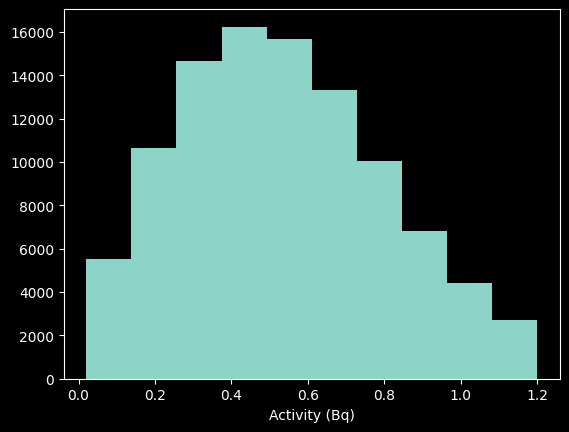

90% credible interval for activity: [ 0.131 , 1.012 ]


In [5]:
# Find the 90% credible interval for the activity

a_list = [dict['a'] for dict in chain]
plt.hist(a_list)
plt.xlabel('Activity (Bq)')
plt.show()

a_low = np.percentile(a_list,5.)
a_high = np.percentile(a_list,95.)

print('90% credible interval for activity: [',round(a_low,3),',',round(a_high,3),']')

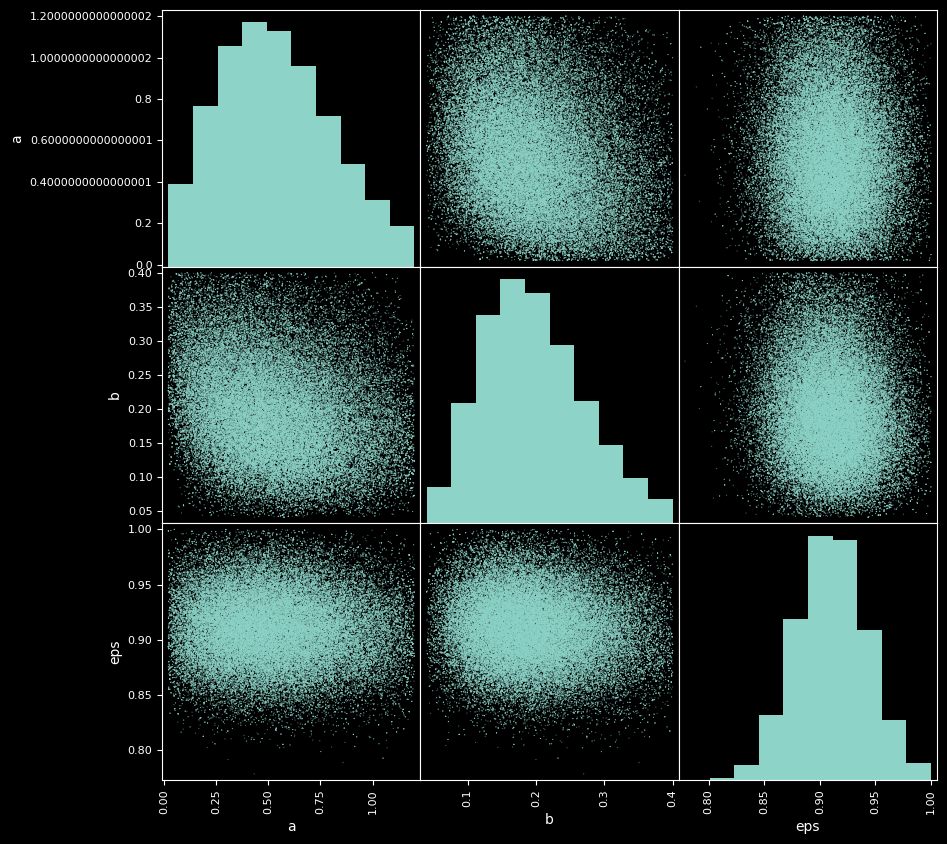

In [6]:
# Explore the 3D posterior by looking at all 1D and 2D projections

df = pd.DataFrame(chain)
pd.plotting.scatter_matrix(df,s=3,figsize=[10,10]);